In [85]:
import torch
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
project_root = os.path.dirname(os.path.abspath(''))
print(project_root)
sys.path.append(os.path.abspath(''))
predictions = torch.load(os.path.join(project_root, 'results/predictions1.pt'))

/Users/evanheus/Desktop/AFP


In [87]:
# Extract main components
pred_tensor = predictions['predictions']
actual_tensor = predictions['actual_returns']

# Print basic information
print(f"Predictions shape: {pred_tensor.shape}")
print(f"Actual returns shape: {actual_tensor.shape}")

# Calculate mean absolute error
mae = torch.mean(torch.abs(pred_tensor - actual_tensor))


Predictions shape: torch.Size([3277, 10, 3])
Actual returns shape: torch.Size([3277, 10, 3])


In [88]:
# Calculate hit rate
hit_rate = torch.mean((pred_tensor[:,5,0].sign() == actual_tensor[:,5,0].sign()).float())
print(hit_rate)

tensor(0.4724)


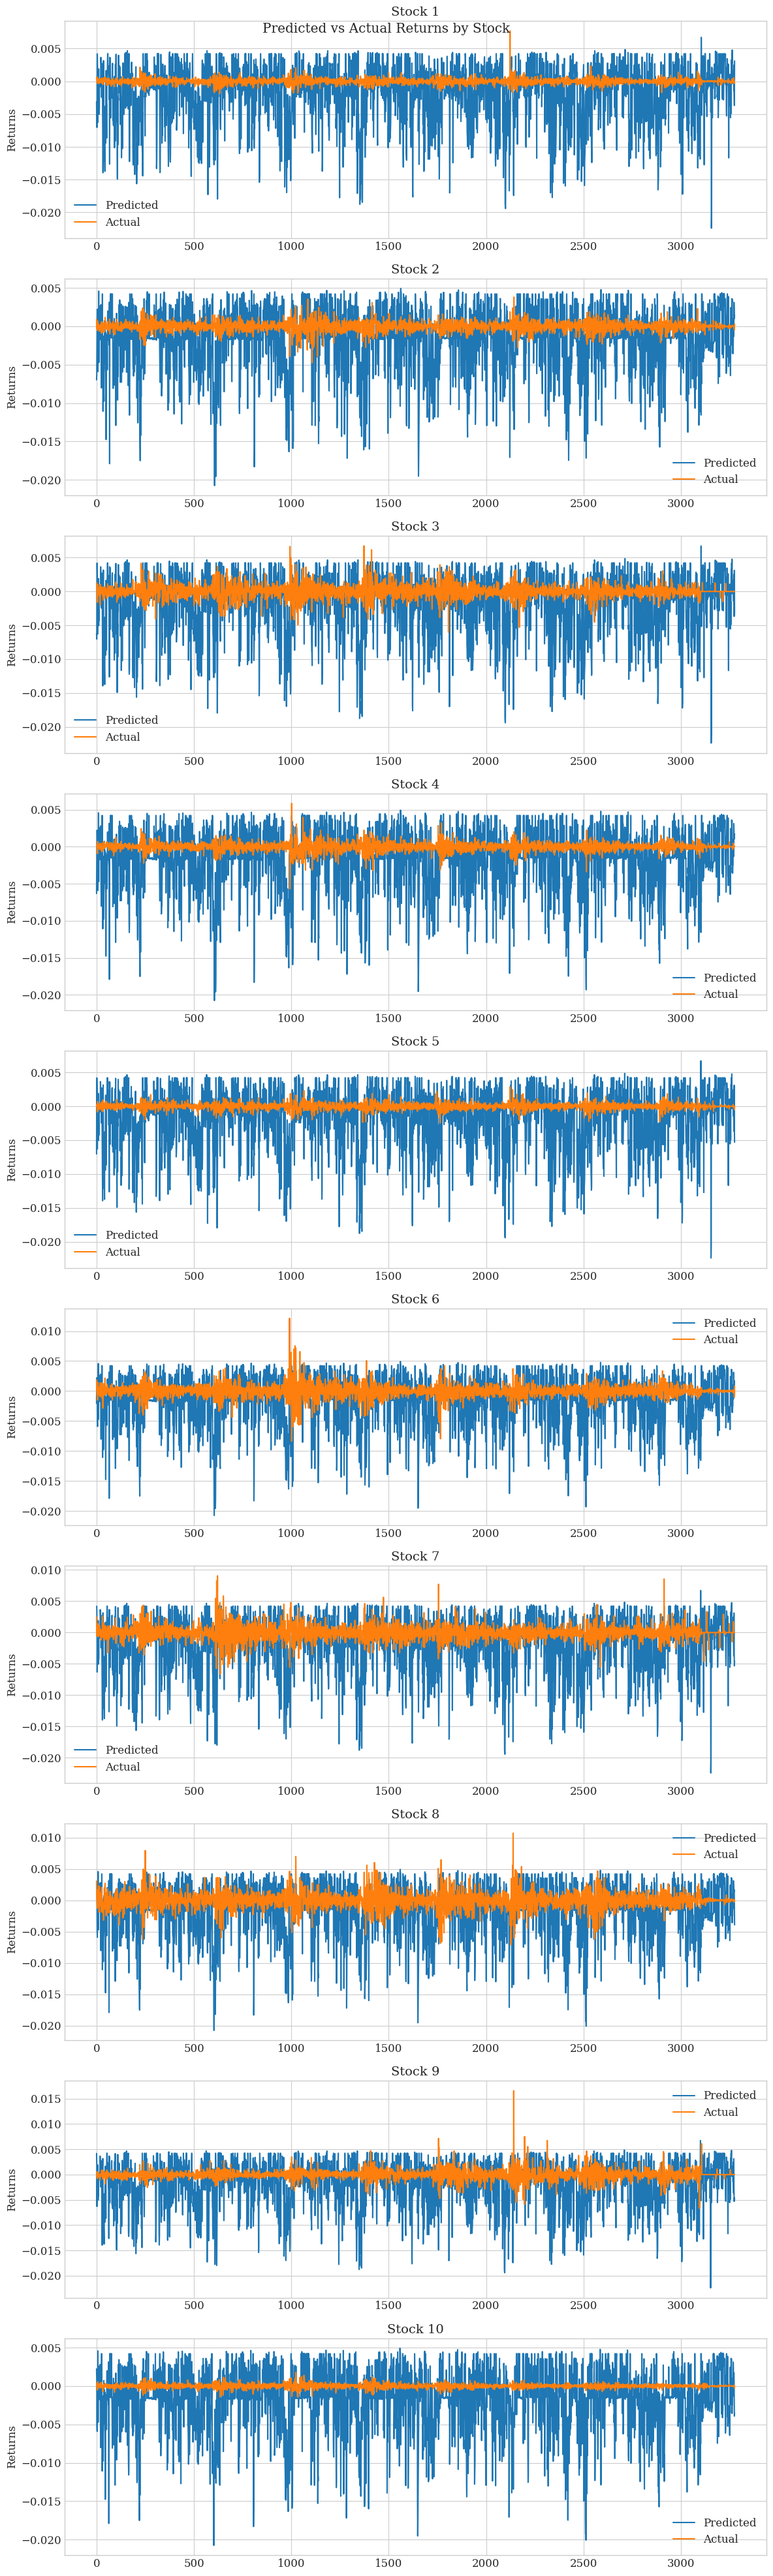

In [89]:
# Select a few stocks to plot (e.g., first 5 stocks)
num_stocks = 10
fig, axes = plt.subplots(num_stocks, 1, figsize=(12, 4*num_stocks))
fig.suptitle('Predicted vs Actual Returns by Stock')

for i in range(num_stocks):
    # Get predicted and actual returns for stock i
    pred_returns = pred_tensor[:, i, 0].detach().numpy()
    actual_returns = actual_tensor[:, i, 0].detach().numpy()
    
    # Plot on the corresponding subplot
    axes[i].plot(pred_returns, label='Predicted')
    axes[i].plot(actual_returns, label='Actual')
    axes[i].set_title(f'Stock {i+1}')
    axes[i].legend()
    axes[i].set_ylabel('Returns')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [90]:
# Get the first 10 returns for the first stock
first_stock_returns = actual_tensor[:10, 0, 0]
print("First 10 returns for stock 0:")
print(first_stock_returns)

First 10 returns for stock 0:
tensor([ 4.5963e-04,  6.5631e-04,  8.7451e-05, -2.6233e-04,  1.3120e-04,
        -2.6236e-04,  5.2487e-04, -8.7432e-05,  1.3116e-04,  3.0600e-04])


In [91]:
ticker_to_index = {'AAPL': 0, 'AMZN': 1, 'DDOG': 2, 'GOOGL': 3, 'MSFT': 4, 'NVDA': 5, 'ROKU': 6, 'TSLA': 7, 'ZM': 8, 'SPY': 9}

In [92]:
mean_returns_per_stock

array([ 1.06809255e-05,  1.09600675e-05, -8.05994602e-06,  8.24869357e-06,
       -3.12264289e-06,  1.45513447e-05,  2.61181902e-05,  2.38658685e-06,
       -2.38316136e-07,  3.55226796e-06])

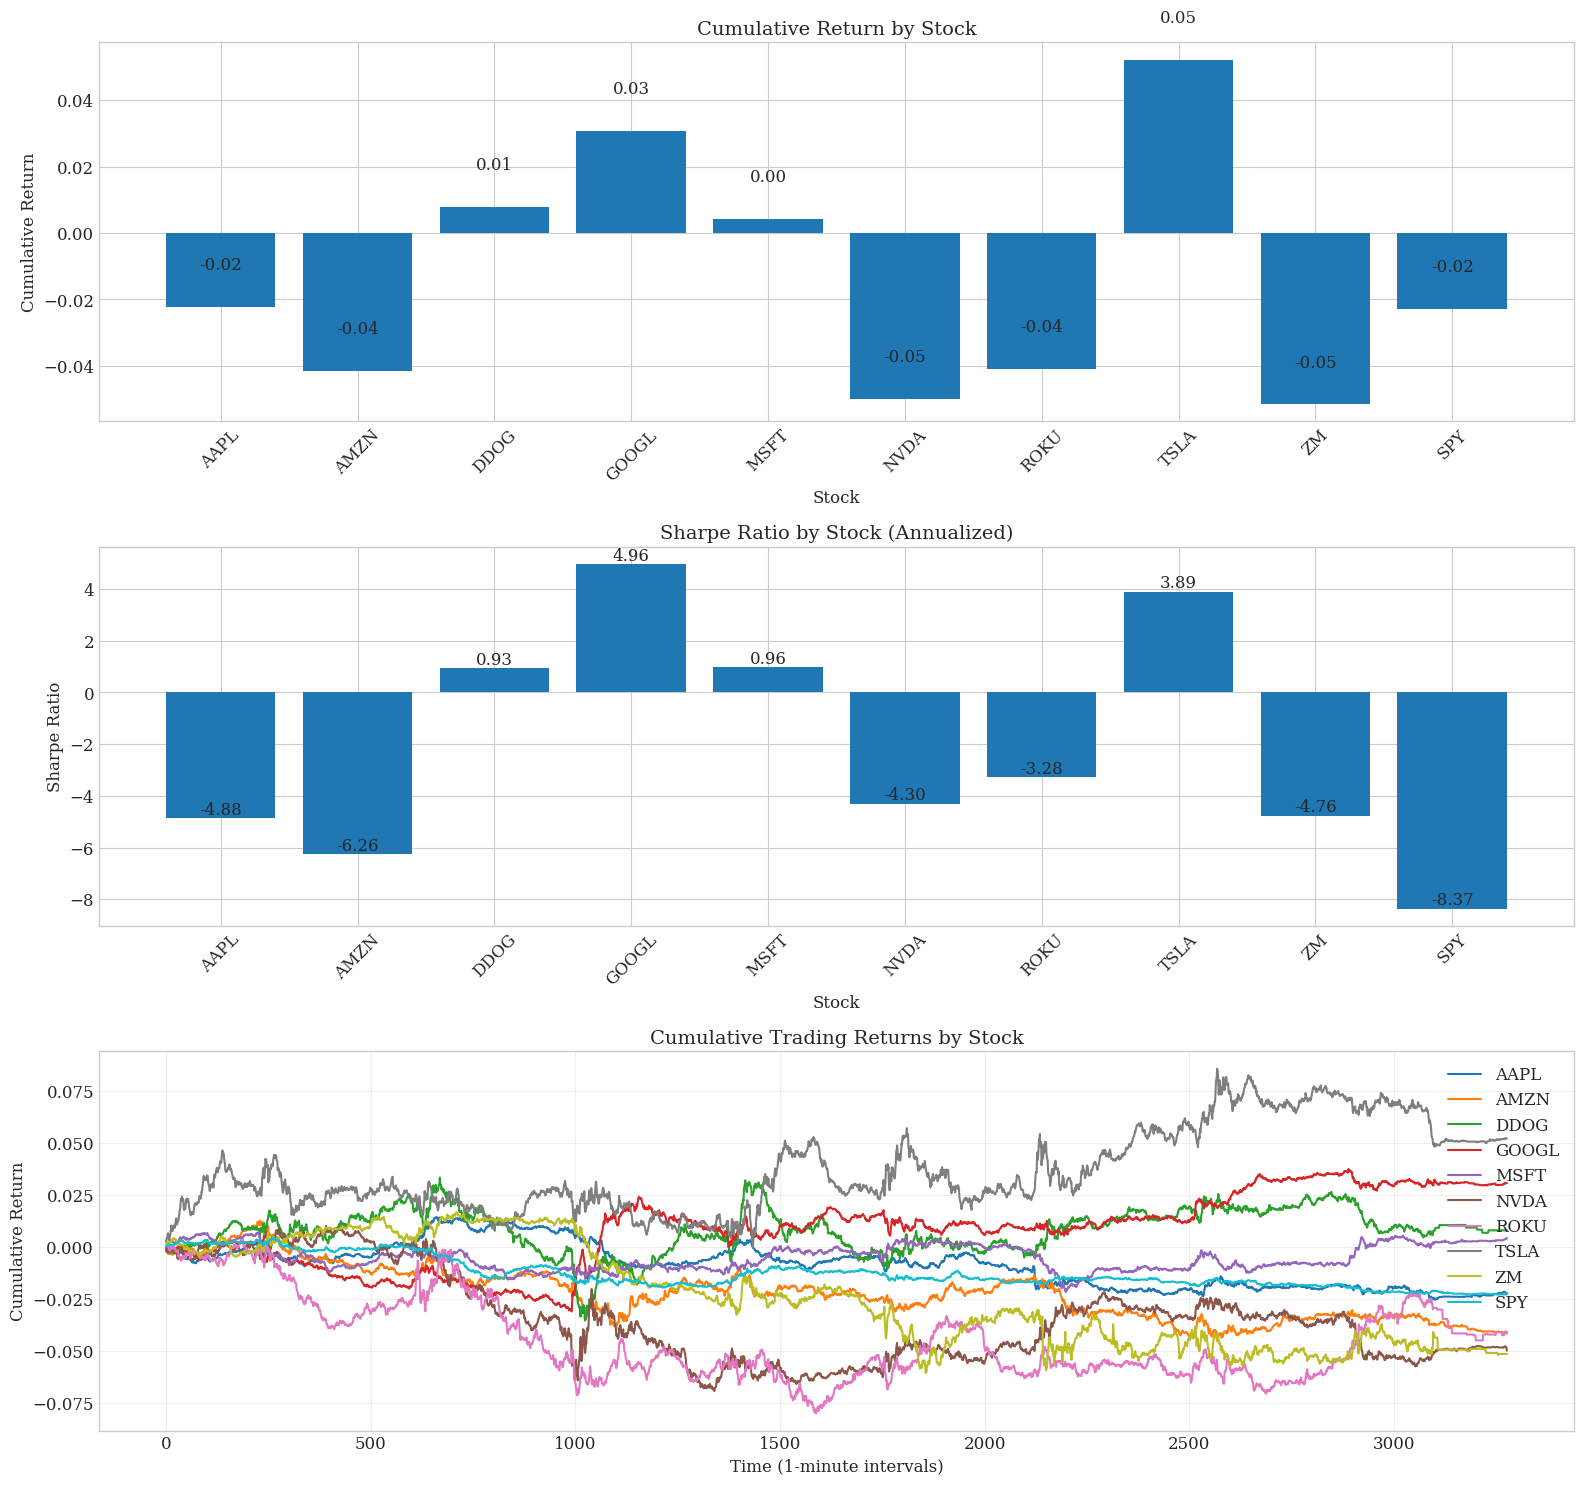

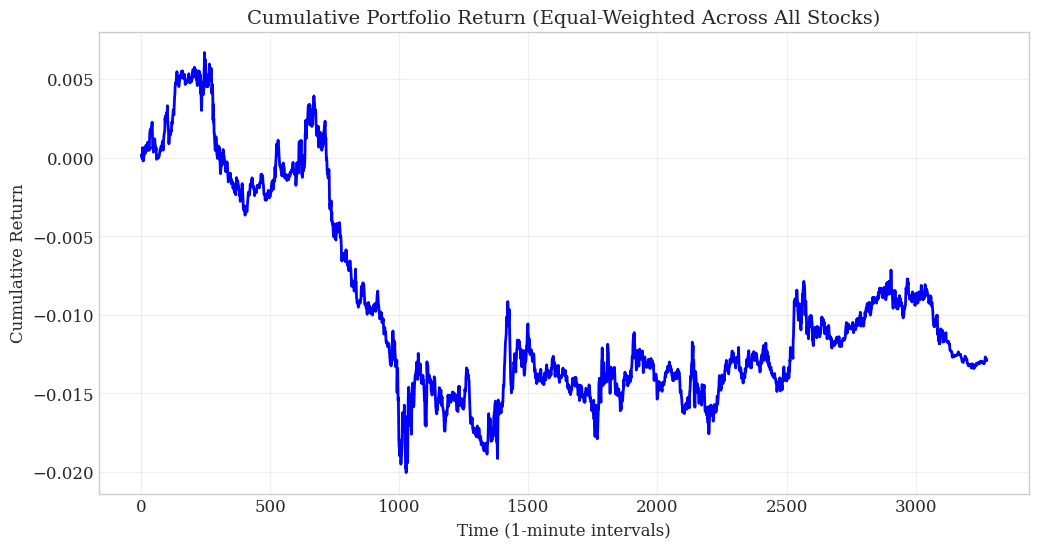


=== Individual Stock Metrics ===
AAPL:
  Annualized Return: -0.666372
  Annualized Risk: 0.136661
  Sharpe Ratio: -4.8761
  Cumulative Return: -0.022279

AMZN:
  Annualized Return: -1.251370
  Annualized Risk: 0.199740
  Sharpe Ratio: -6.2650
  Cumulative Return: -0.041505

DDOG:
  Annualized Return: 0.285085
  Annualized Risk: 0.305524
  Sharpe Ratio: 0.9331
  Cumulative Return: 0.007981

GOOGL:
  Annualized Return: 0.925242
  Annualized Risk: 0.186652
  Sharpe Ratio: 4.9571
  Cumulative Return: 0.030733

MSFT:
  Annualized Return: 0.137492
  Annualized Risk: 0.142848
  Sharpe Ratio: 0.9625
  Cumulative Return: 0.004253

NVDA:
  Annualized Return: -1.478075
  Annualized Risk: 0.343611
  Sharpe Ratio: -4.3016
  Cumulative Return: -0.049962

ROKU:
  Annualized Return: -1.185592
  Annualized Risk: 0.361187
  Sharpe Ratio: -3.2825
  Cumulative Return: -0.040849

TSLA:
  Annualized Return: 1.614065
  Annualized Risk: 0.415122
  Sharpe Ratio: 3.8882
  Cumulative Return: 0.052265

ZM:
  Ann

In [93]:
ticker_to_index = {'AAPL': 0, 'AMZN': 1, 'DDOG': 2, 'GOOGL': 3, 'MSFT': 4, 'NVDA': 5, 'ROKU': 6, 'TSLA': 7, 'ZM': 8, 'SPY': 9}
# Create a reverse mapping to get ticker from index
index_to_ticker = {v: k for k, v in ticker_to_index.items()}

# Initialize arrays to store results
trading_returns = np.zeros((pred_tensor.shape[0], pred_tensor.shape[1]))
positions = np.zeros((pred_tensor.shape[0], pred_tensor.shape[1]))

# For each stock
for stock in range(pred_tensor.shape[1]):
    # Get predictions and actual returns for this stock
    stock_preds = pred_tensor[:, stock, 0].numpy()
    stock_actuals = actual_tensor[:, stock, 0].numpy()
    
    # Generate positions based on predictions
    positions[:, stock] = np.where(stock_preds > 0, 1, -1)
    
    # Calculate returns
    trading_returns[:, stock] = positions[:, stock] * stock_actuals

# Calculate proper time scaling factors
minutes_in_year = 390 * 252  # trading minutes per year (390 minutes per day, 252 trading days)
window_length_minutes = pred_tensor.shape[0]

# For individual stocks
mean_returns_per_stock = trading_returns.mean(axis=0)
std_returns_per_stock = trading_returns.std(axis=0)

# Annualized metrics per stock
annualized_returns_per_stock = mean_returns_per_stock * minutes_in_year
annualized_risk_per_stock = std_returns_per_stock * np.sqrt(minutes_in_year)

# Correct Sharpe ratio calculation
sharpe_ratio_per_stock = annualized_returns_per_stock / annualized_risk_per_stock

# Calculate cumulative returns properly (assuming returns are not log returns)
cumulative_return_per_stock = np.prod(1 + trading_returns, axis=0) - 1

# Calculate portfolio returns (assuming equal weighting across stocks)
portfolio_returns = trading_returns.mean(axis=1)
# Cumulative portfolio return using proper compounding
cumulative_portfolio_return = np.cumprod(1 + portfolio_returns) - 1

# Portfolio metrics with proper annualization
portfolio_mean_return = portfolio_returns.mean()
portfolio_std_return = portfolio_returns.std()

# Annualized portfolio metrics
annualized_portfolio_return = portfolio_mean_return * minutes_in_year
annualized_portfolio_risk = portfolio_std_return * np.sqrt(minutes_in_year)

# Correct portfolio Sharpe ratio
portfolio_sharpe = annualized_portfolio_return / annualized_portfolio_risk

# Calculate total return
total_return = cumulative_portfolio_return[-1]

# Get ticker names for plotting
tickers = [index_to_ticker.get(i, f"Unknown-{i}") for i in range(pred_tensor.shape[1])]

# Plot individual stock metrics
plt.figure(figsize=(16, 15))

# Bar chart for cumulative returns
plt.subplot(3, 1, 1)
bars = plt.bar(range(len(tickers)), cumulative_return_per_stock)
plt.title('Cumulative Return by Stock', fontsize=14)
plt.xlabel('Stock', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.xticks(range(len(tickers)), tickers, rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}',
             ha='center', va='bottom', rotation=0)

# Bar chart for Sharpe ratios
plt.subplot(3, 1, 2)
bars = plt.bar(range(len(tickers)), sharpe_ratio_per_stock)
plt.title('Sharpe Ratio by Stock (Annualized)', fontsize=14)
plt.xlabel('Stock', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.xticks(range(len(tickers)), tickers, rotation=45)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.2f}',
             ha='center', va='bottom', rotation=0)

# Line chart for cumulative returns over time
plt.subplot(3, 1, 3)
proper_cumulative_returns = np.cumprod(1 + trading_returns, axis=0) - 1
for stock in range(min(len(tickers), 10)):  # Limit to 10 stocks for readability
    plt.plot(proper_cumulative_returns[:, stock], label=tickers[stock])
plt.title('Cumulative Trading Returns by Stock', fontsize=14)
plt.xlabel('Time (1-minute intervals)', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(cumulative_portfolio_return, 'b-', linewidth=2)
plt.title('Cumulative Portfolio Return (Equal-Weighted Across All Stocks)', fontsize=14)
plt.xlabel('Time (1-minute intervals)', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Create a table of performance metrics
performance_data = {
    'Ticker': tickers,
    'Annualized Return': annualized_returns_per_stock,
    'Annualized Risk': annualized_risk_per_stock,
    'Sharpe Ratio': sharpe_ratio_per_stock,
    'Cumulative Return': cumulative_return_per_stock
}

# Print detailed stock metrics
print("\n=== Individual Stock Metrics ===")
for i, ticker in enumerate(tickers):
    print(f"{ticker}:")
    print(f"  Annualized Return: {annualized_returns_per_stock[i]:.6f}")
    print(f"  Annualized Risk: {annualized_risk_per_stock[i]:.6f}")
    print(f"  Sharpe Ratio: {sharpe_ratio_per_stock[i]:.4f}")
    print(f"  Cumulative Return: {cumulative_return_per_stock[i]:.6f}")
    print()

# Print portfolio metrics
print("\n=== Portfolio Metrics (equal-weighted) ===")
print(f"Annualized Portfolio Return: {annualized_portfolio_return:.6f}")
print(f"Annualized Portfolio Risk: {annualized_portfolio_risk:.6f}")
print(f"Total Portfolio Return: {total_return:.6f}")
print(f"Portfolio Sharpe Ratio (Annualized): {portfolio_sharpe:.4f}")

# Print some additional useful metrics
hit_rate = np.mean(np.sign(trading_returns) == np.sign(positions))
print(f"Strategy Hit Rate: {hit_rate:.4f}")
print(f"Number of Trading Periods: {window_length_minutes}")
print(f"Annualization Factor Used: √({minutes_in_year}/{window_length_minutes}) = {np.sqrt(minutes_in_year/window_length_minutes):.4f}")

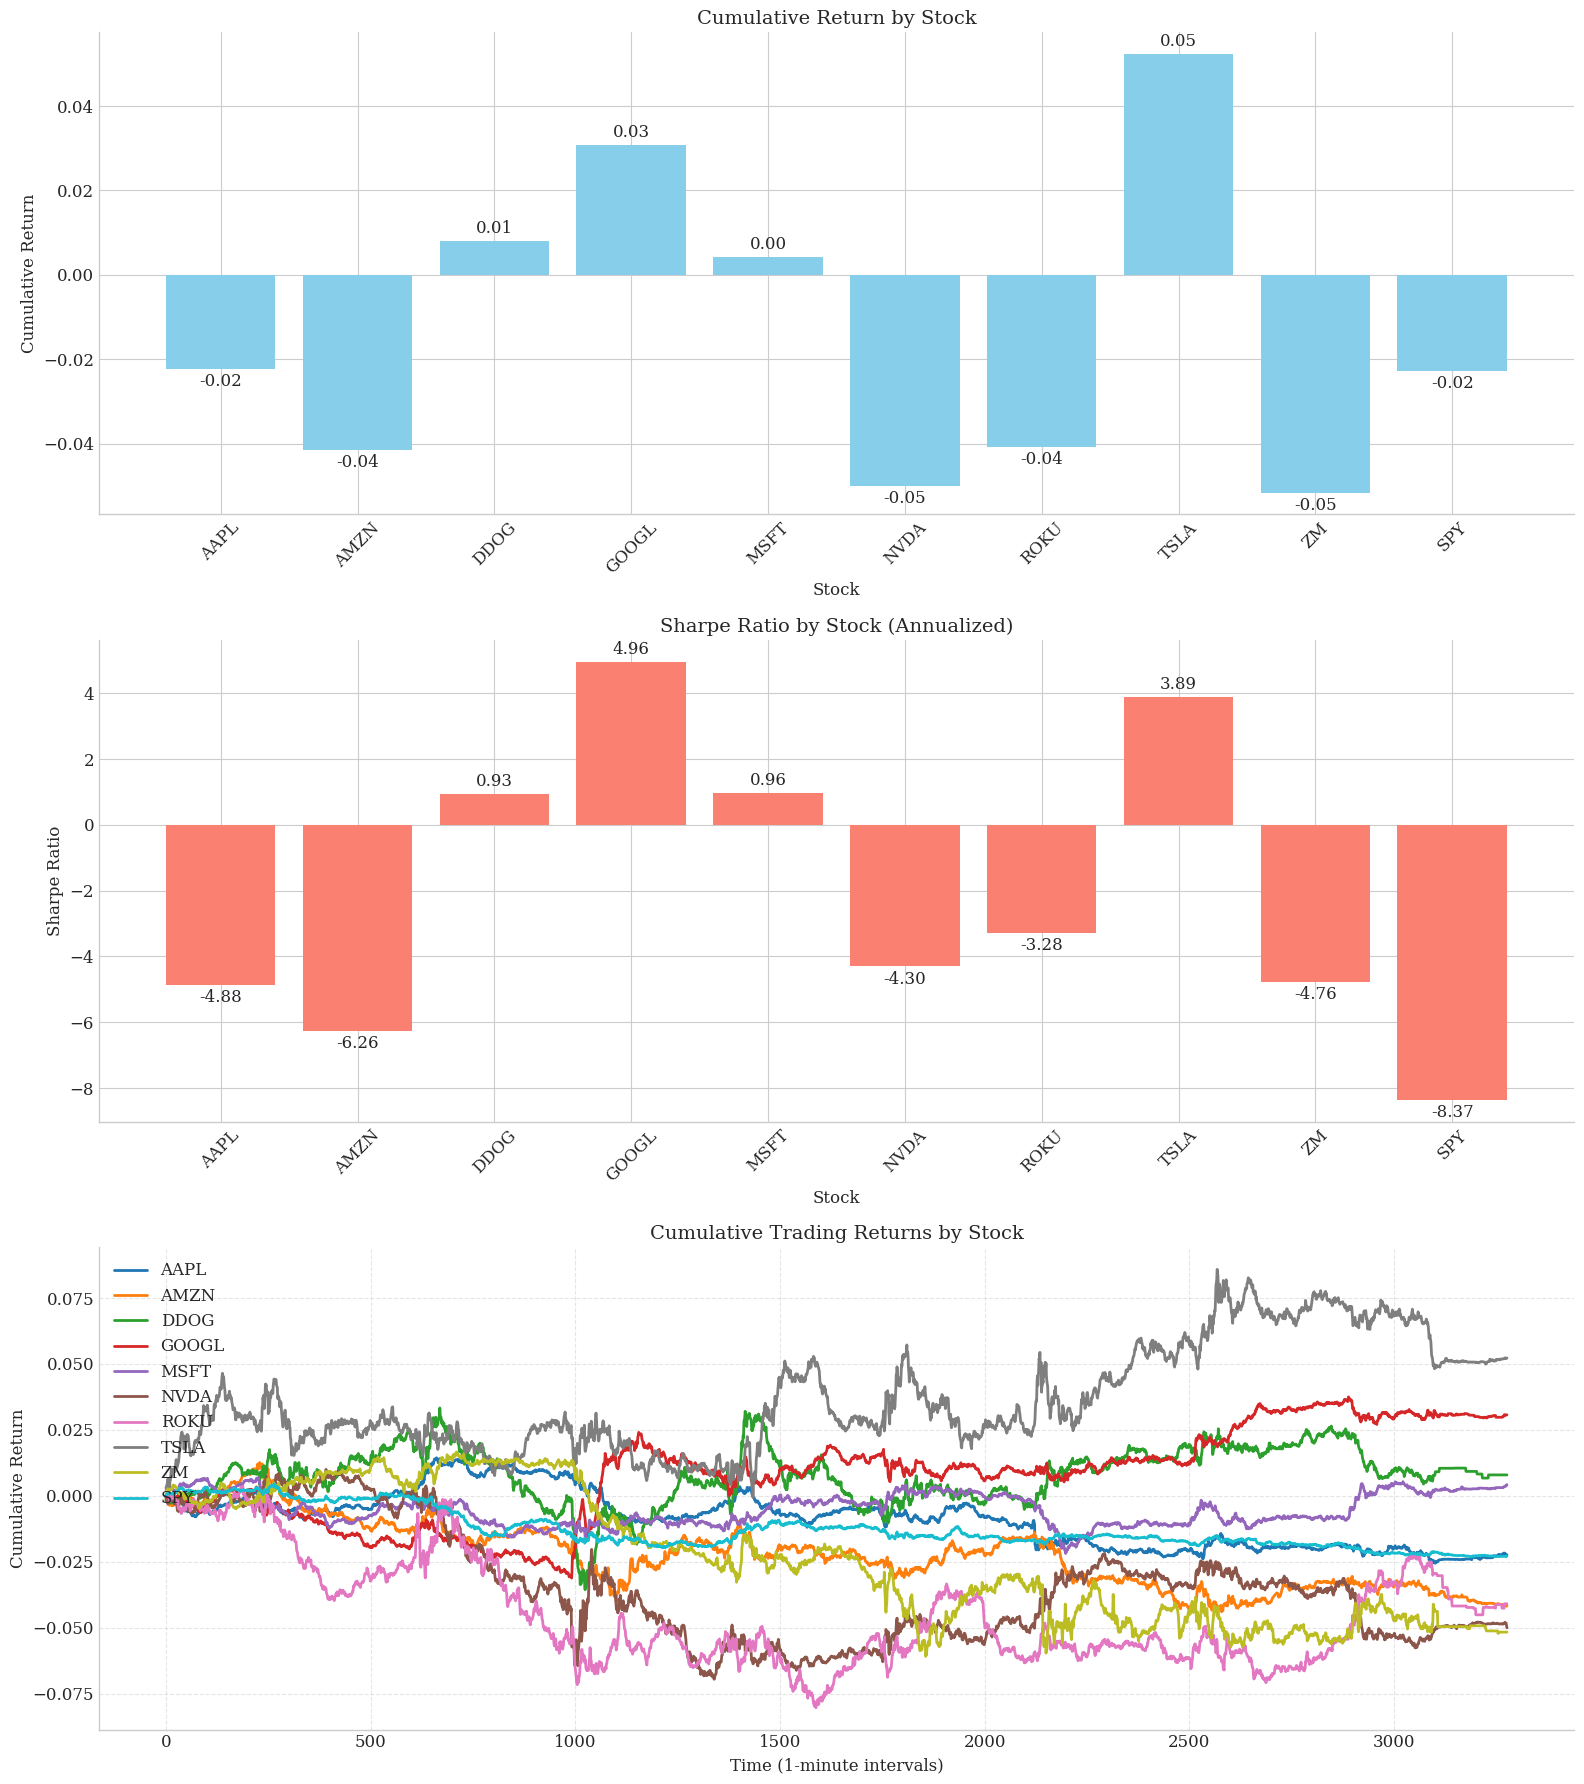

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# Apply a professional style and update font properties
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'text.usetex': False  # Change to True if you prefer LaTeX rendering
})

# Plot individual stock metrics
fig, axs = plt.subplots(3, 1, figsize=(16, 18))

# Bar chart for cumulative returns
bars = axs[0].bar(range(len(tickers)), cumulative_return_per_stock, color='skyblue')
axs[0].set_title('Cumulative Return by Stock')
axs[0].set_xlabel('Stock')
axs[0].set_ylabel('Cumulative Return')
axs[0].set_xticks(range(len(tickers)))
axs[0].set_xticklabels(tickers, rotation=45)
axs[0].bar_label(bars, fmt='%.2f', padding=3)

# Remove top/right spines for a cleaner look
for spine in ['right', 'top']:
    axs[0].spines[spine].set_visible(False)

# Bar chart for Sharpe ratios
bars = axs[1].bar(range(len(tickers)), sharpe_ratio_per_stock, color='salmon')
axs[1].set_title('Sharpe Ratio by Stock (Annualized)')
axs[1].set_xlabel('Stock')
axs[1].set_ylabel('Sharpe Ratio')
axs[1].set_xticks(range(len(tickers)))
axs[1].set_xticklabels(tickers, rotation=45)
axs[1].bar_label(bars, fmt='%.2f', padding=3)
for spine in ['right', 'top']:
    axs[1].spines[spine].set_visible(False)

# Line chart for cumulative returns over time
for stock in range(min(len(tickers), 10)):
    axs[2].plot(proper_cumulative_returns[:, stock], label=tickers[stock], linewidth=2)
axs[2].set_title('Cumulative Trading Returns by Stock')
axs[2].set_xlabel('Time (1-minute intervals)')
axs[2].set_ylabel('Cumulative Return')
axs[2].legend(loc='upper left', frameon=False)
axs[2].grid(True, linestyle='--', alpha=0.5)
for spine in ['right', 'top']:
    axs[2].spines[spine].set_visible(False)

plt.tight_layout()
plt.show()
